## Importing

In [57]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import get_point_biserial, get_binned_prediction
from utils import contain_substr
import seaborn as sns

pn.extension()


### Initialize Variables and Widgets

In [58]:

df = pd.read_csv('output/run_sem/results_corpus_entropy.csv')
df['chapter'] = df['run'].apply(lambda x: int(x[2]))
# df['number_boundaries'] = df['number_boundaries'].clip(upper=150)

available_tags = list(df['tag'].unique())
available_tags = [x for x in available_tags if 'june' in x and 'pca30' in x]
default_tag = available_tags[0]
available_metrics = list(df.columns)
default_metric = ['mean_pe', 'pearson_r', 'epoch', 'n_event_models', 'active_event_models', 'number_boundaries', 'entropy']

multi_tag_select = pn.widgets.MultiSelect(name='Select 2 or 3 Tags for Comparison', value=[default_tag], options=available_tags,
                                          height=100)
multi_metric_select = pn.widgets.MultiSelect(name='Select Metrics to Visualize', value=default_metric, options=available_metrics,
                                             height=100)

train_checkbox = pn.widgets.Checkbox(name='Display Train?', value=False)
valid_checkbox = pn.widgets.Checkbox(name='Display Valid?', value=True)

In [60]:
alfas = list(set([x.split('_')[-2] for x in available_tags]))
lmdas = list(set([x.split('_')[-1] for x in available_tags]))

multi_alfa_select = pn.widgets.MultiSelect(name='Select Alfas', value=[alfas[0]], options=alfas)
multi_lmda_select = pn.widgets.MultiSelect(name='Select Lmdas', value=[lmdas[0]], options=lmdas)


@pn.depends(multi_alfa_select.param.value, multi_lmda_select.param.value)
def alfa_lmda_to_tag(multi_alfa_select, multi_lmda_select):
    select_tags = []
    for alfa in multi_alfa_select:
        for lmda in multi_lmda_select:
            select = f'{alfa}_{lmda}'
            select_tags.extend([t for t in available_tags if select in t])
    multi_tag_select.value = select_tags

### Define necessary functions for PE

In [61]:
@pn.depends(multi_tag_select, multi_metric_select)
def matrix_visualize(multi_tag_select, multi_metric_select):
    df_select = df[(df['tag'].isin(multi_tag_select)) & (df['is_train'] == True)]
    sns_plot = sns.pairplot(df_select[multi_metric_select + ['tag']], hue='tag', palette='bright',
                            kind='reg', plot_kws={'scatter_kws': {'alpha': 0.3}}, height=1.6)
    fig = sns_plot.fig
    #     fig.set_size_inches(7,5)
    #     fig.savefig('matrix.png')
    plt.close()
    return fig

In [62]:
import param


class ActionExample(param.Parameterized):
    """
    Demonstrates how to use param.Action to trigger an update.
    """

    #     number = param.Number(default=0)

    action = param.Action(lambda x: x.param.trigger('action'), label='Update!')

    #     @param.depends('action')
    #     def get_number(self):
    #         return self.number

    @param.depends('action')
    def matrix_visualize(self):
        print(f'Update pane with new tags: tags={multi_tag_select.value}')
        df_select = df[(df['tag'].isin(multi_tag_select.value))]
        if not (train_checkbox.value and valid_checkbox.value):
            if train_checkbox.value:
                df_select = df_select[(df_select['is_train'] == True)]
            elif valid_checkbox.value:
                df_select = df_select[(df_select['is_train'] == False)]
            sns_plot = sns.pairplot(df_select[multi_metric_select.value + ['tag']], hue='tag', palette='bright',
                                    kind='reg', plot_kws={'scatter_kws': {'alpha': 0.3}}, height=1.6)
        else:
            sns_plot = sns.pairplot(df_select[multi_metric_select.value + ['is_train']], hue='is_train', palette='bright',
                                    kind='reg', plot_kws={'scatter_kws': {'alpha': 0.3}}, height=1.6)
        fig = sns_plot.fig
        #     fig.set_size_inches(7,5)
        fig.savefig('matrix.png')
        plt.close()
        return fig


action_matrix = ActionExample()

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Select Alfas', options=['alfa1E+06', ...], value=['alfa1E+06'])
        [1] MultiSelect(name='Select Lmdas', options=['lmda1E+08', ...], value=['lmda1E+08'])
    [2] Row
        [0] MultiSelect(height=100, name='Select Metrics t..., options=['run', 'grain', ...], value=['mean_pe', 'pearson_r', ...])
        [1] ParamFunction(function)
        [2] MultiSelect(height=100, name='Select 2 or 3..., options=['june_12_pca30_grid_alfa1...], value=['june_12_pca30_grid_alfa1...])
    [3] Row
        [0] Button(name='Update!')
        [1] Checkbox(name='Display Train?')
        [2] Checkbox(name='Display Valid?', value=True)
    [4] ParamMethod(method)
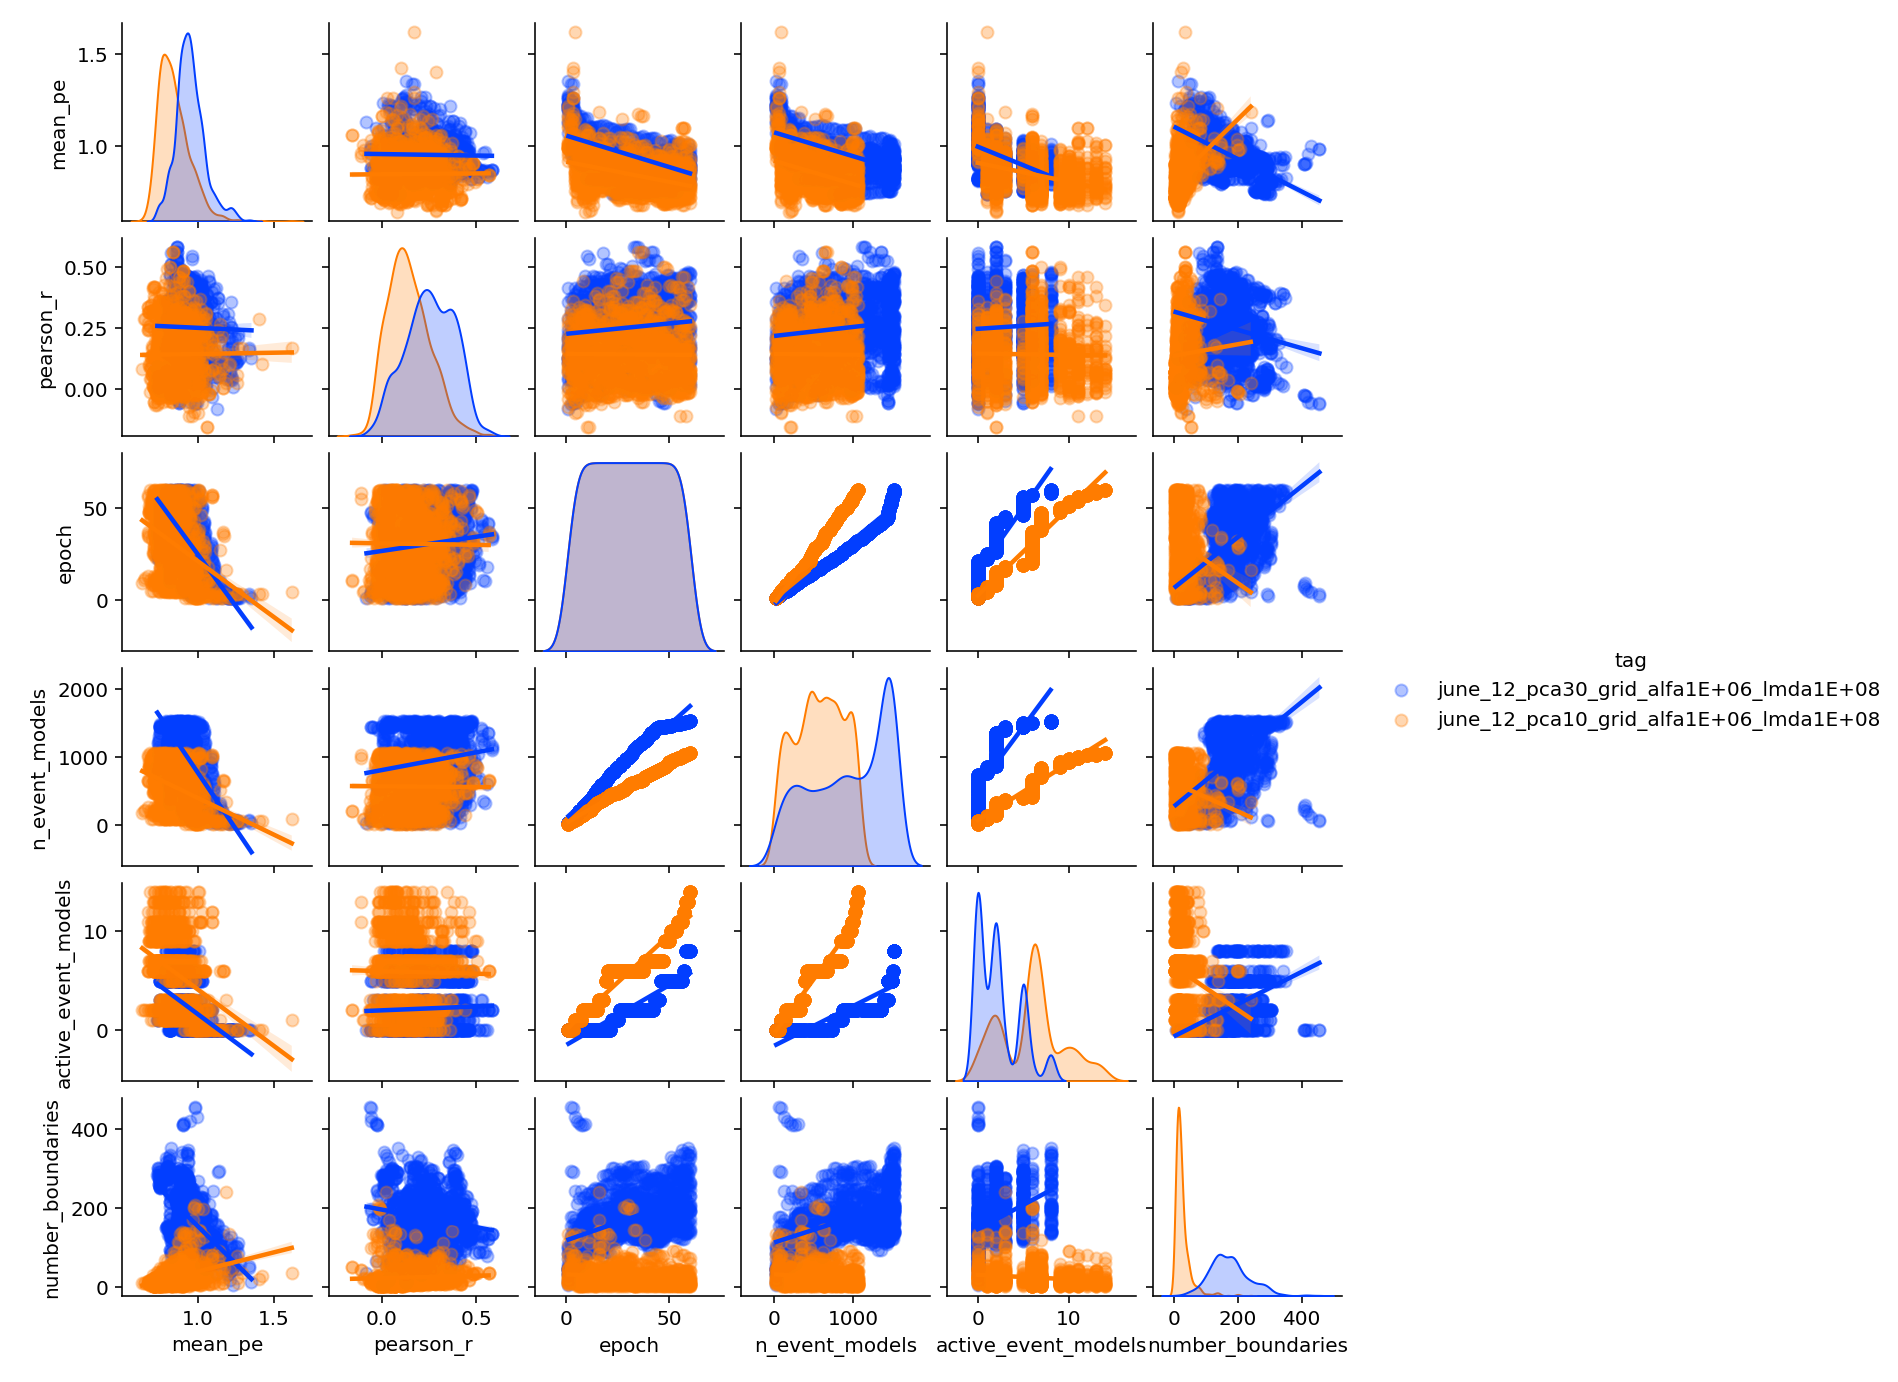

In [63]:
dashboard = pn.Column(
    pn.Row('Compare Scatter Matrices Across Configurations'),
    pn.Row(multi_alfa_select, multi_lmda_select),
    pn.Row(multi_metric_select, alfa_lmda_to_tag, multi_tag_select),
    pn.Row(pn.panel(action_matrix.param, show_labels=True, show_name=False, margin=0),
           train_checkbox,
           valid_checkbox),
    action_matrix.matrix_visualize
)

# Launch the dashboard
dashboard.servable()

In [29]:
# sem_readout = pkl.load(open('output/run_sem/may_22_df60_nh5_grid_alfa1E+02_lmda5E+01/1.1.10_kinect_trimmay_22_df60_nh5_grid_alfa1E+02_lmda5E+01_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 60)[0]
# for av in active_events:
#     print(sem_readout['Sigma'][av], sem_readout['c'][av])
#
#

[0.00828862 0.09429414 0.11066648 0.06687535 0.09204145] 730.0
[0.012774   0.05152259 0.06960698 0.05740044 0.05274115] 333.0
[0.00779874 0.05350644 0.05192491 0.08800552 0.13385951] 1071.0
[0.00196262 0.01831394 0.0172084  0.03383049 0.03026884] 2367.0
[0.00065395 0.02753891 0.02517502 0.03476128 0.03945177] 17668.0
[0.00365942 0.05221855 0.04600674 0.04964857 0.06235338] 1901.0
[0.33040094 0.20529253 0.52344852 0.15219908 0.1904636 ] 861.0
[0.00430547 0.04189534 0.04797418 0.05648528 0.04091552] 1143.0
[0.00395036 0.03779599 0.04330077 0.05047217 0.04191081] 1262.0
[0.01165989 0.05938227 0.04565928 0.05575494 0.05145122] 360.0
[0.00624952 0.02862211 0.02841718 0.03220691 0.03003009] 579.0
[0.0046107  0.03298938 0.04112485 0.03255774 0.05301665] 844.0
[0.00274133 0.01906901 0.01719419 0.01259686 0.02860324] 1445.0
[0.00652319 0.03981294 0.03854345 0.03446748 0.10433893] 739.0


In [30]:
# v = sem_readout
#

In [ ]:
#         df_post = pd.DataFrame(v['post'])
#         df_filtered_post = df_post.loc[:, (df_post > 1e-2).any(axis=0)]
#         sns.lineplot(data=df_filtered_post, ax=ax1)
#

In [ ]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# events = sem_readout['c'][sem_readout['c'] > 0]
# sns.distplot(range(len(events)), bins=len(events), hist_kws={"weights": events}, kde=False)
# # plt.hist(counted_data.keys(), weights=counted_data.values(), bins=range(50))
#

In [22]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# events = sem_readout['c'][sem_readout['c'] > 0]
# sns.distplot(range(len(events)), bins=len(events), hist_kws={"weights": events}, kde=False)
# # plt.hist(counted_data.keys(), weights=counted_data.values(), bins=range(50))
#

NameError: name 'ax1' is not defined

In [ ]:
# sem_readout['c'][sem_readout['c'] > 0]
#

In [ ]:
# sem_readout = pkl.load(open('output/run_sem/may_22_df60_nh5_grid_alfa1E+02_lmda1E+03/1.1.10_kinect_trimmay_22_df60_nh5_grid_alfa1E+02_lmda1E+03_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 60)[0]
# for av in active_events:
#     print(sem_readout['Sigma'][av], sem_readout['c'][av])
#


In [ ]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])

In [ ]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])

In [ ]:
# # checking kappa to make sure it's 0 during validation
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/1.1.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])
# print('---')
# sem_readout = pkl.load(open('output/run_sem/may_20_alfa0_appear_cont/2.2.10_kinect_trimmay_20_alfa0_appear_cont_diagnostic_20.pkl', 'rb'))
# active_events = np.where(sem_readout['c'] > 600)[0]
# for av in active_events:
#     print(sem_readout['c'][av])